In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


# Camera calibration

In [2]:
# prepare object points, [0, 0, 0], [1, 0, 0], [2, 0, 0],...,[7, 5, 0]
# why should define such a list? why should it be transposed?
# how does transpose and reshape work?
objp = np.zeros((6*8, 3), np.float32)
objp[:, :2] = np.mgrid[0:8, 0:6].transpose().reshape(-1, 2)

In [3]:
# arrays to store object points and image points
objpoints = []
imgpoints = []

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

images = glob.glob("calibration_wide/GOPR00*.jpg")
for frame in images:
    img = cv2.imread(frame)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (8, 6), None)

    # if found, add object points, image points
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
#         img = cv2.drawChessboardCorners(img, (8, 6), corners, ret)
#         plt.imshow(img)
print(len(objpoints))
print(len(imgpoints))

35
35


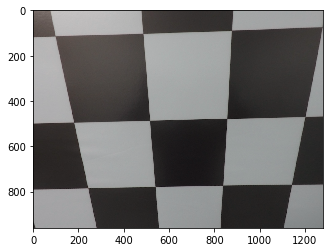

In [4]:
img = cv2.imread("calibration_wide/test_image.jpg")
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

h, w = img.shape[:2]
mtx2, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))

# undistort
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(dst)

# Undistort and Transform

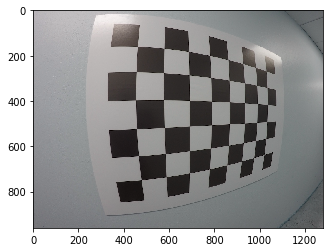

In [5]:
img = cv2.imread("calibration_wide/GOPR0032.jpg")
plt.imshow(img)
nx = 8
ny = 6

In [6]:
def corners_unwarp(img, nx, ny, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (8, 6), None)
    if ret:
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        src = np.float32([corners[0][0], corners[7][0], corners[47][0], corners[40][0]])
#         print(src)
        dst = np.float32([[100, 100], [1150,100], [1150, 850], [100, 850]])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, (1280, 960), flags=cv2.INTER_LINEAR)
        
    return undist, warped, M

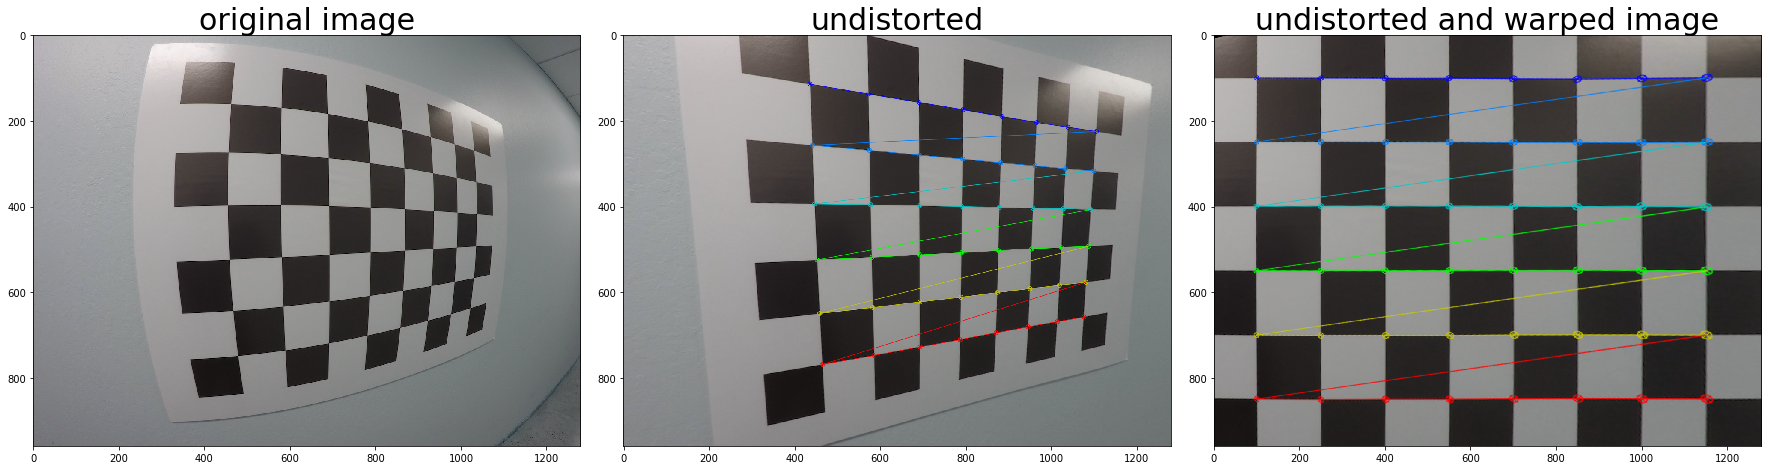

In [7]:
undist, top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('original image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('undistorted', fontsize=30)
ax3.imshow(top_down)
ax3.set_title('undistorted and warped image', fontsize=30)

plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.)

# Sobel

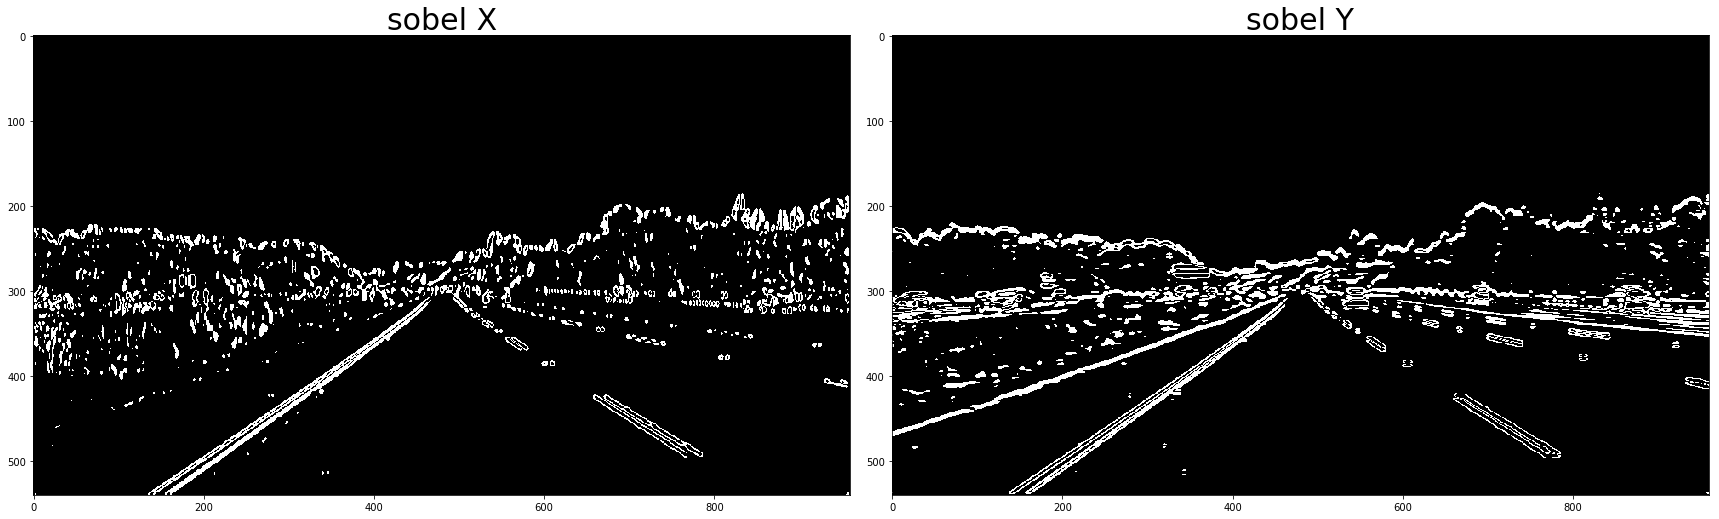

In [10]:
img = cv2.imread("sobeltest.jpg")

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    if (orient=='x'):
        sobel = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary

sxbinary = abs_sobel_thresh(img, orient='x', sobel_kernel=9, thresh_min=30, thresh_max=100)
sybinary = abs_sobel_thresh(img, orient='y', sobel_kernel=9, thresh_min=30, thresh_max=100)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(sxbinary, cmap='gray')
ax1.set_title('sobel X', fontsize=30)
ax2.imshow(sybinary, cmap='gray')
ax2.set_title('sobel Y', fontsize=30)

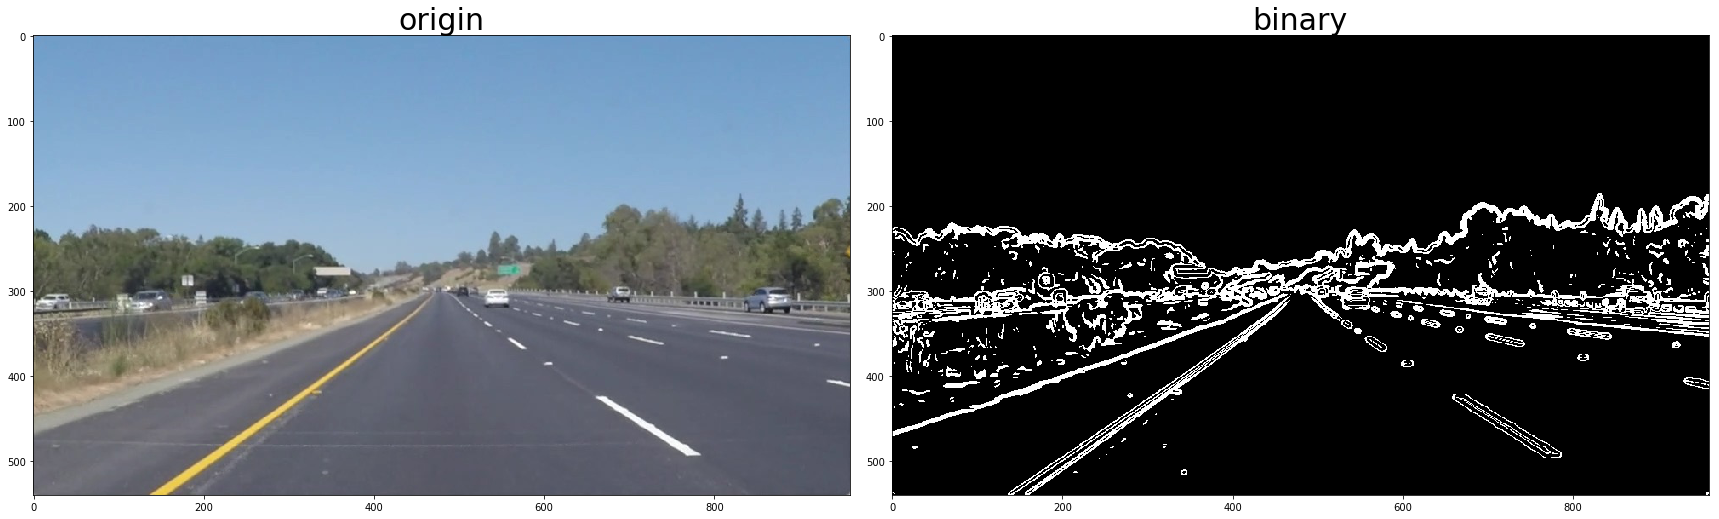

In [11]:
img = cv2.imread("sobeltest.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def mag_thresh(img, sobel_kernel= 3, thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    sobelx = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255 * sobel / np.max(sobel))
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary
    
mag_binary = mag_thresh(img, sobel_kernel=9, thresh_min=30, thresh_max=100)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img, cmap='gray')
ax1.set_title('origin', fontsize=30)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('binary', fontsize=30)
    

# Direction

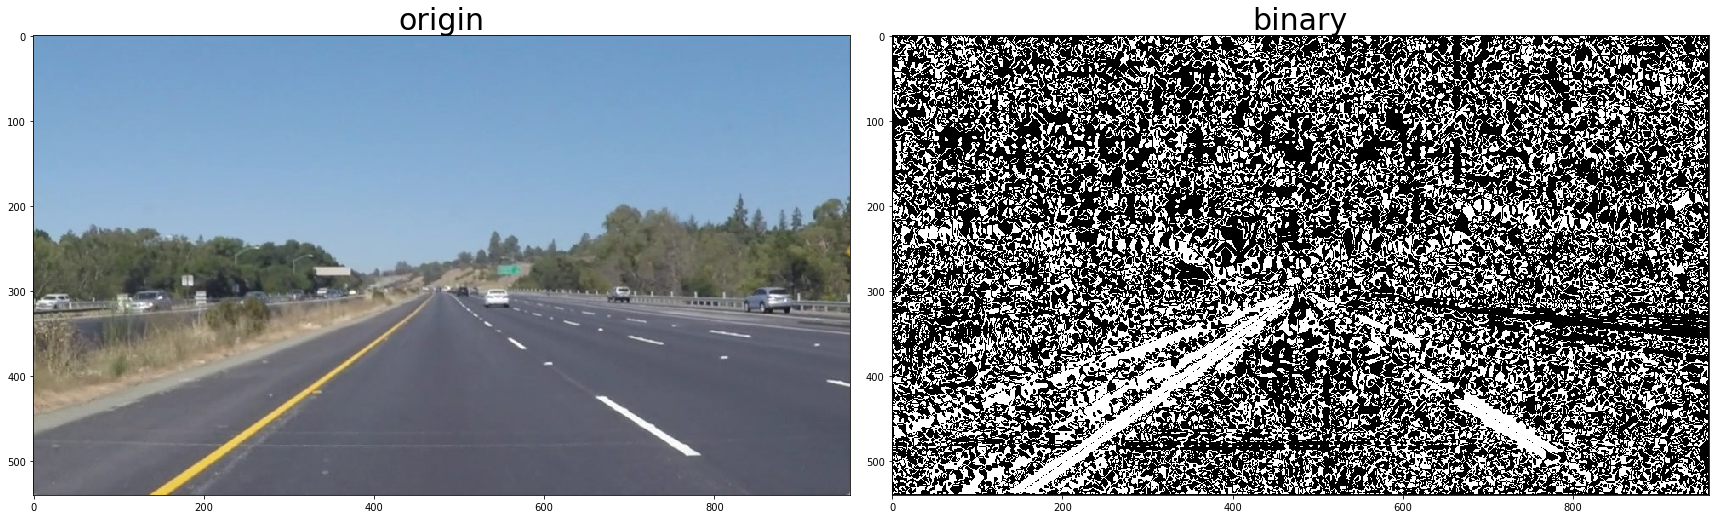

In [12]:
img = cv2.imread("sobeltest.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def dir_thresh(img, sobel_kernel= 3, thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    sobelx = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
#     scaled_gradir = np.uint8(np.pi * gradir / 2 * np.max(gradir)) 
#     why not normalized?
    binary = np.zeros_like(gradir)
    binary[(gradir >= thresh_min) & (gradir <= thresh_max)] = 1
    return binary
    
dir_binary = dir_thresh(img, sobel_kernel=15, thresh_min=0.7, thresh_max=1.3)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img, cmap='gray')
ax1.set_title('origin', fontsize=30)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('binary', fontsize=30)

# Combine Thresholds
Now consider how to use various aspects of your gradient measurements(x, y, magnitude, direction) to isolate lane-line pixels. Specifically, think about how you can use **thresholds of the x and y gradients** or **the overall gradient magnitude and direction** to focus on pixels that are likely to be part of the lane lines.

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

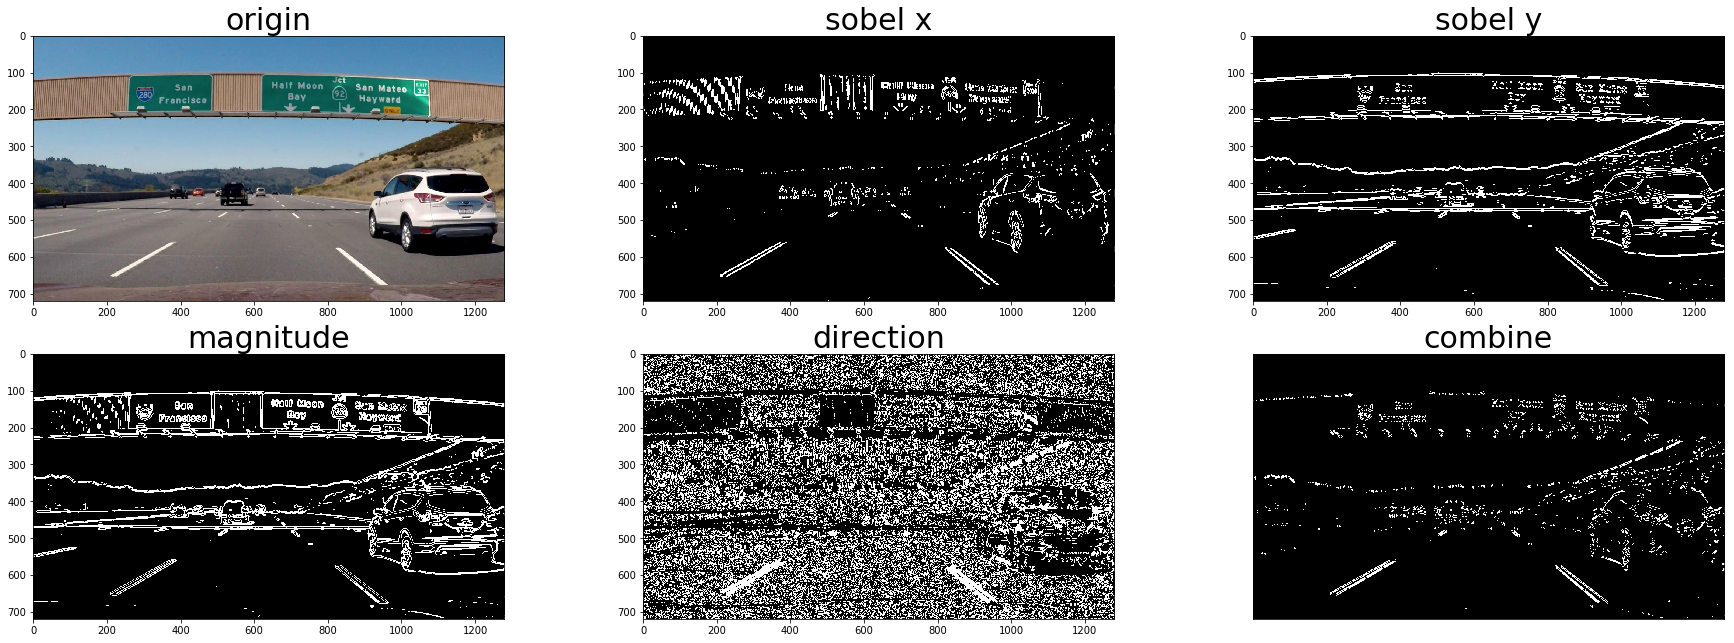

In [21]:
img = cv2.imread("signs_vehicles_xygrad.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

sx_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=9, thresh_min=30, thresh_max=100)
sy_binary = abs_sobel_thresh(img, orient='y', sobel_kernel=9, thresh_min=30, thresh_max=100)
mag_binary = mag_thresh(img, sobel_kernel=9, thresh_min=30, thresh_max=100)
dir_binary = dir_thresh(img, sobel_kernel=15, thresh_min=0.7, thresh_max=1.3)
combined = np.zeros_like(dir_binary)
# threshold of x,y or magnitude and direction
combined[((sx_binary == 1) & (sy_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

f, axs = plt.subplots(2, 3, figsize=(24, 9))
# f.tight_layout()
axs[0, 0].imshow(img), axs[0, 0].set_title('origin', fontsize=30)
axs[0, 1].imshow(sx_binary, cmap='gray') ,axs[0, 1].set_title('sobel x', fontsize=30)
axs[0, 2].imshow(sy_binary, cmap='gray'), axs[0, 2].set_title('sobel y', fontsize=30)
axs[1, 0].imshow(mag_binary, cmap='gray'), axs[1, 0].set_title('magnitude', fontsize=30)
axs[1, 1].imshow(dir_binary, cmap='gray'), axs[1, 1].set_title('direction', fontsize=30)
axs[1, 2].imshow(combined, cmap='gray'), axs[1, 2].set_title('combine', fontsize=30)
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.0)